In [1]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Loading the SonarQube analysis results

In [2]:
#load results from csv file
df = pd.read_csv('sonar_results_new.csv')

We will drop sqale_rating since this value is same (1.0) for all projects.

In [3]:
# Drop the column with non-numeric values
df_numeric = df.drop(columns=['project_name','ai_assisted','sqale_rating'])
df_numeric.head(20)

,files,ncloc,bugs,code_smells,sqale_index,duplicated_lines_density,vulnerabilities,blocker_violations,critical_violations,major_violations,minor_violations,info_violations
0,77,11388,3,276,3053,10.8,0,1,68,175,31,4
1,1,210,0,1,5,0.0,0,0,0,1,0,0
2,8,328,0,11,77,0.0,0,0,2,7,2,0
3,1,1191,0,115,764,0.0,0,0,88,21,6,0
4,13,786,0,24,171,0.0,0,0,8,11,5,0
5,2,256,0,7,71,0.0,0,0,3,3,1,0
6,3,122,0,2,9,0.0,0,0,1,0,1,0
7,11,1536,0,17,238,0.0,0,0,10,6,1,0
8,5,2153,1,31,428,84.2,0,1,18,7,6,0
9,2,581,0,3,24,10.2,0,0,1,0,2,0


Removing near-zero variance columns: vulnerabilities, blocker_violations, bugs, info_violations
and files

In [4]:
df_numeric = df_numeric.drop(columns=['files','vulnerabilities','blocker_violations','bugs', 'info_violations'])

# Person Correlation

The Pearson correlation coefficient is a measure of the linear relationship between two continuous variables. It ranges from -1 to 1:

A value of 1 indicates a perfect positive linear relationship.
A value of -1 indicates a perfect negative linear relationship.
A value of 0 indicates no linear relationship.

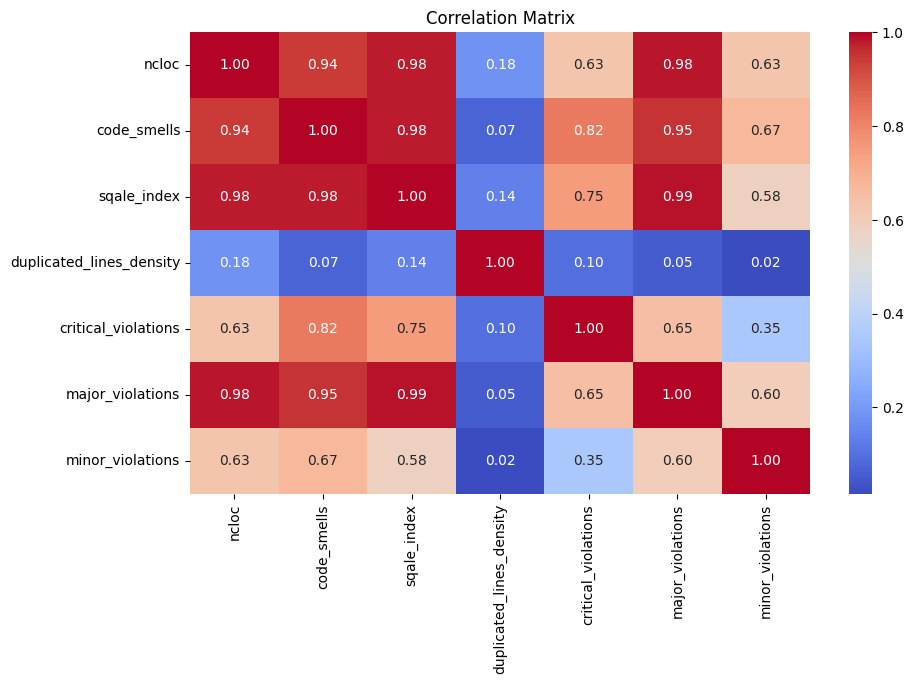

In [5]:
# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Display the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Initial analysis:
- **files and ncloc**: when collecting the dataset we tried to keep the distribution of project sizes similar between human-written and AI-assisted projects, in this sense, the number of files is not adding value. This variable correaltes strongly with ncloc, and so it might introduce multicolinearity without offering new insights.
- **ncloc**: The ncloc strongly correlates with many metrics of technical debt (larger projects consistently have more bugs,sqale_index,code_smells, major_violations,minor_violations,info_violations), we will consider normalizing or controlling for size.

In [6]:
# Normalizing the metrics by dividing by 'nloc'
df_numeric['code_smell_density'] = df_numeric['code_smells']/df_numeric['ncloc']
df_numeric['sqale_index_density'] = df_numeric['sqale_index'] / df_numeric['ncloc']
df_numeric['critical_violation_density'] = df_numeric['critical_violations'] / df_numeric['ncloc']
df_numeric['major_violation_density'] = df_numeric['major_violations'] / df_numeric['ncloc']
df_numeric['minor_violation_density'] = df_numeric['minor_violations'] / df_numeric['ncloc']

In [7]:
# Creating new DataFrame with just the final columns
df_normalized = df_numeric[[
                            #'bug_density',
                            'code_smell_density',
                            'sqale_index_density',
                            #'vulnerability_density',
                            #'duplicated_lines_density',
                            #'blocker_violation_density',
                            'critical_violation_density',
                            'major_violation_density',
                            'minor_violation_density',
                            #'info_violation_density'
                            ]]

df_normalized.head()

,code_smell_density,sqale_index_density,critical_violation_density,major_violation_density,minor_violation_density
0,0.024236,0.268089,0.005971,0.015367,0.002722
1,0.004762,0.023810,0.000000,0.004762,0.000000
2,0.033537,0.234756,0.006098,0.021341,0.006098
3,0.096558,0.641478,0.073887,0.017632,0.005038
4,0.030534,0.217557,0.010178,0.013995,0.006361


                            code_smell_density  sqale_index_density  \
code_smell_density                    1.000000             0.865271   
sqale_index_density                   0.865271             1.000000   
critical_violation_density            0.805809             0.856336   
major_violation_density               0.620128             0.568261   
minor_violation_density               0.464698             0.159458   

                            critical_violation_density  \
code_smell_density                            0.805809   
sqale_index_density                           0.856336   
critical_violation_density                    1.000000   
major_violation_density                       0.450708   
minor_violation_density                       0.032005   

                            major_violation_density  minor_violation_density  
code_smell_density                         0.620128                 0.464698  
sqale_index_density                        0.568261               

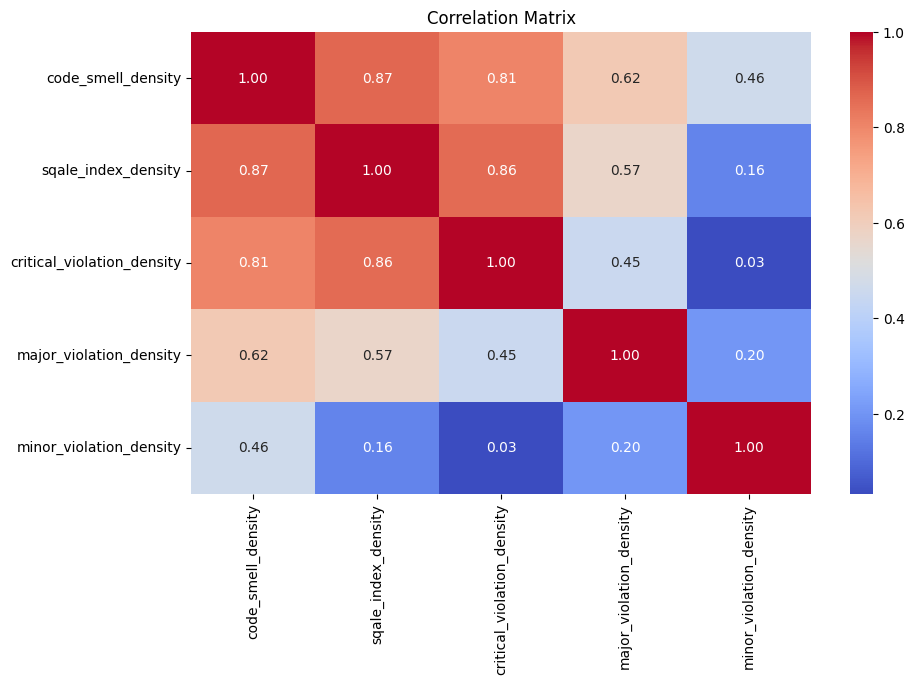

In [8]:
# Compute correlation matrix
correlation_matrix_new = df_normalized.corr()
print(correlation_matrix_new)
# Display the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_new, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

- **sqale_index and code_smells**: These variables measure technical debt in minutes and the number of code smells in the project. They show a very strog correlation (0.99), meaning that including both might introduce multicollinearity, which can distort the model's estimates. We decided to drop code smells, bearing in mind that sqale_index is highly relevant to the goal of the rq1 since it is a direct measure of technical debt.


# Visually evaluating distribution (Box plots)

<ipython-input-9-501bd6132c61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized.loc[:, 'ai_assisted'] = df.loc[:, 'ai_assisted']
<ipython-input-9-501bd6132c61>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized.loc[:, 'ai_assisted_label'] = df_normalized['ai_assisted'].map({0: 'Human Written', 1: 'AI Assisted'})


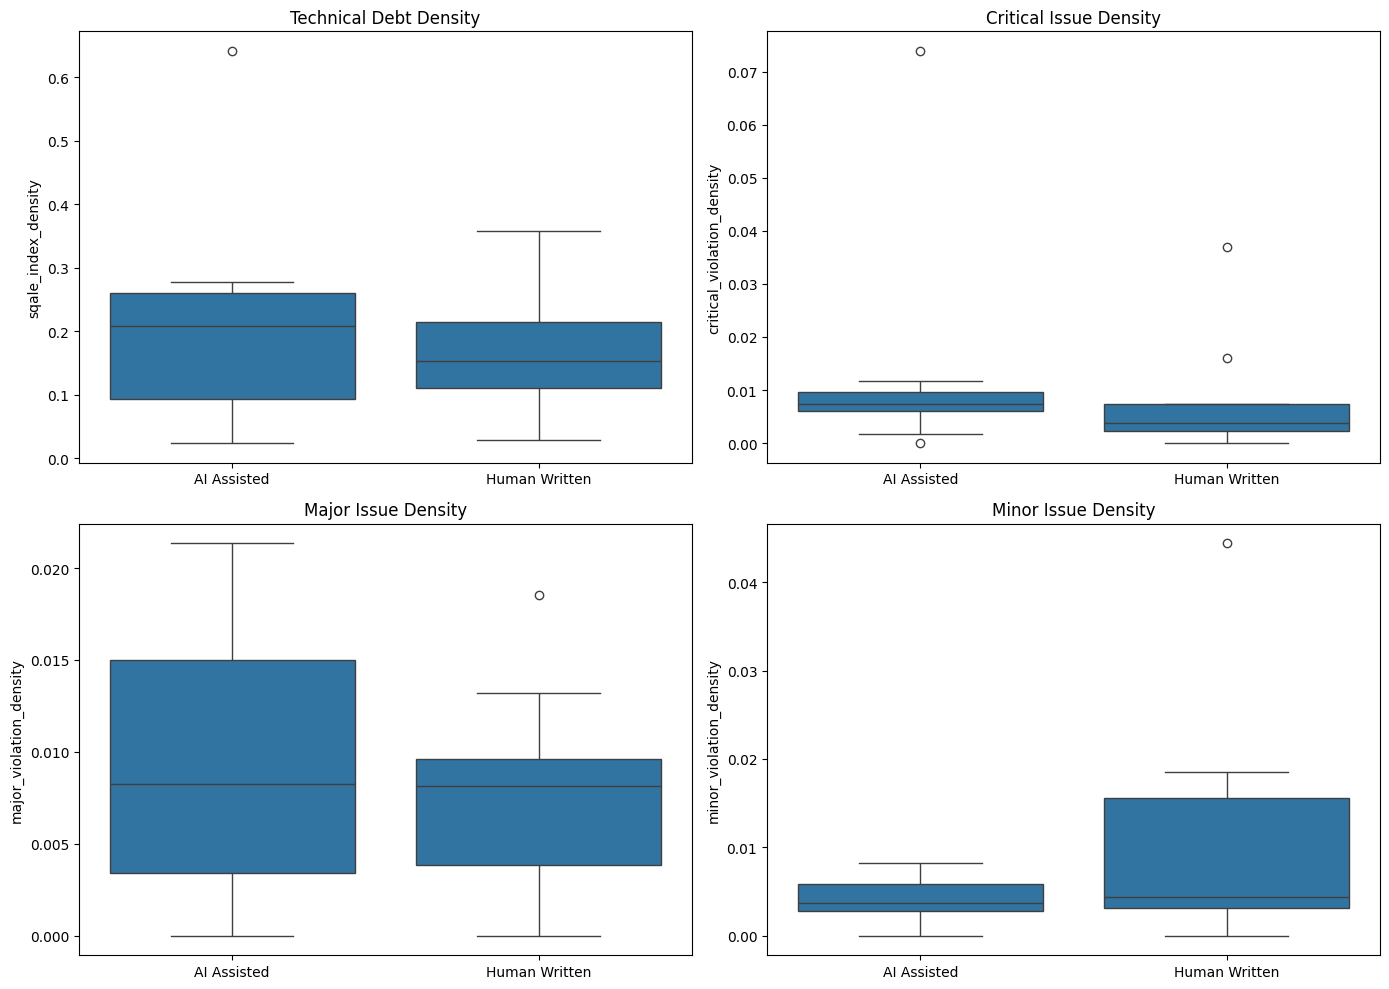

In [9]:
# Add 'ai_assisted' column to the df_normalized dataframe using .loc
df_normalized.loc[:, 'ai_assisted'] = df.loc[:, 'ai_assisted']

# Create a new column to label the two categories using .loc
df_normalized.loc[:, 'ai_assisted_label'] = df_normalized['ai_assisted'].map({0: 'Human Written', 1: 'AI Assisted'})

# List the metrics to visualize
metrics = [
          #'bug_density',
           'sqale_index_density',
           #'code_smell_density',
          #'duplicated_lines_density',
           #'blocker_violation_density',
           'critical_violation_density',
          'major_violation_density',
           'minor_violation_density'
           ]
metric_map={
            #'bug_density':'Bug Density',
            'sqale_index_density': 'Technical Debt Density',
            #'code_smell_density': 'Code Smell Density',
            #'duplicated_lines_density': 'Duplication Density',
            #'blocker_violation_density': 'Blocker Issue Density',
            'critical_violation_density': 'Critical Issue Density',
          'major_violation_density': 'Major Issue Density',
            'minor_violation_density': 'Minor Issue Density'
            }

# Set up the plot
plt.figure(figsize=(14, 10))

# Loop over the selected metrics to create a box plot for each
for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)  # 2 rows, 4 columns
  sns.boxplot(x='ai_assisted_label', y=metric, data=df_normalized)
  plt.title(f'{metric_map[metric]}')
  plt.xlabel('')
  plt.ylabel(f'{metric}')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Evaluating differences: Mann-Whitney U test

In [10]:
p_values = []

# Perform the Mann-Whitney U test for each metric
for metric in metrics:
    # Group the data based on 'ai_assisted' and get the values for the metric
    group_human = df_normalized[df_normalized['ai_assisted'] == 0][metric]
    group_ai = df_normalized[df_normalized['ai_assisted'] == 1][metric]

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(group_human, group_ai)
    p_values.append(p_value)

# Correction of p-values: Benjamini-Hochberg (BH)

In [11]:
# Apply Benjamini-Hochberg correction to the p-values
rej, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Store the results in a DataFrame
results_df = pd.DataFrame({
    'Metric': metrics,
    'P-Value': p_values,
    'Corrected P-Value (Benjamini-Hochberg)': pvals_corrected,
    'Reject Null Hypothesis (BH)': rej
})

# Show the results
print(results_df)

                       Metric   P-Value  \
0         sqale_index_density  0.677585   
1  critical_violation_density  0.405326   
2     major_violation_density  0.676435   
3     minor_violation_density  0.383957   

   Corrected P-Value (Benjamini-Hochberg)  Reject Null Hypothesis (BH)  
0                                0.677585                        False  
1                                0.677585                        False  
2                                0.677585                        False  
3                                0.677585                        False  
